### 1. Clean raw answers

In [7]:
# List of CSV files representing different tasks
csv_files = [
    './framed_results.csv',
    './unframed_results.csv',
]

In [12]:
import pandas as pd
import numpy as np
import re
import os

def clean_raw_answers(file_path):
    """
    Clean raw answers from a CSV file by extracting only the last list of numbers in the last sentence,
    or by handling cases with two consecutive numbers or the word "both."
    
    Parameters:
    file_path (str): Path to the CSV file
    
    Returns:
    pandas.DataFrame: DataFrame with cleaned parsed answers and any rows with None in parsed answers collected.
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    def extract_digits(x, model_name):
        if pd.isna(x):
            return None
        
        # Convert to string and remove any newline characters
        x = str(x).strip().replace('\n', '')
        
        # Split by sentence-ending punctuation to isolate the last sentence
        sentences = re.split(r'[.!?]\s+', x)
        last_sentence = sentences[-1] if sentences else ""
        
        # First, check for square-bracketed list in the last sentence
        match = re.search(r'\[([\d.,\s]+)\]', last_sentence)
        if match:
            # Parse numbers from the matched group and convert them to floats
            numbers = [float(num.strip()) for num in match.group(1).split(',')]
            return numbers
        
        # Check if model is "LLaMA" and search for two consecutive numbers at the end of the last sentence
        elif model_name == "LLaMA":
            digit_matches = re.findall(r'\b(\d+)\b', last_sentence)
            if len(digit_matches) >= 2:
                # Take the last two numbers
                numbers = [float(digit_matches[-2]), float(digit_matches[-1])]
                return numbers
        
        # Check if "both" is in the sentence, then look for one or two numbers after "both"
        elif "both" in last_sentence:
            # Case 1: Extract two numbers if both are found after "both"
            both_match_two_numbers = re.findall(r'both\s+(\d+)\s+and\s+(\d+)', last_sentence)
            if both_match_two_numbers:
                # If two numbers are matched, return them as a list
                return [float(both_match_two_numbers[0][0]), float(both_match_two_numbers[0][1])]

            # Case 2: Extract a single number after "both" and duplicate it
            both_match_single = re.search(r'both\s+(\d+)', last_sentence)
            if both_match_single:
                value = float(both_match_single.group(1))
                return [value, value]
        
        # If no numbers were found, return None
        return None

    # Apply extraction logic to raw answers
    df['parsed_answers'] = df.apply(lambda row: extract_digits(row['raw_answers'], row['model_name']), axis=1)
    
    # Identify rows with None in 'parsed_answers' before dropping
    none_rows = df[df['parsed_answers'].isna()].copy()
    
    # Drop rows with None in 'parsed_answers' in the original DataFrame
    print(f"Row count before dropping None: {len(df)}")
    df = df.dropna(subset=['parsed_answers'])
    print(f"Row count after dropping None: {len(df)}")
    
    return df, none_rows

# Directory path containing the CSV files
csv_dir = "/home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXP4-Results"
csv_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('_results.csv')]

# Dictionary to store cleaned DataFrames and collect None rows
cleaned_dataframes = {}
none_rows_list = []

# Process each CSV file
for file_path in csv_files:
    try:
        cleaned_df, none_rows = clean_raw_answers(file_path)
        filename = os.path.basename(file_path).replace("_results.csv", "")
        cleaned_dataframes[filename] = cleaned_df
        
        # Add task name and store None rows
        none_rows['task_name'] = filename
        none_rows_list.append(none_rows)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Check if none_rows_list is not empty before concatenating
if none_rows_list:
    none_rows_df = pd.concat(none_rows_list, ignore_index=True)
    # Display the combined DataFrame with all None rows in 'parsed_answers' across tasks
    print("\nAll rows with None values in 'parsed_answers' across tasks:")
    print(none_rows_df)
else:
    print("\nNo rows with None values in 'parsed_answers' were found across tasks.")

# Access each cleaned DataFrame by task name (example usage)
df_framed = cleaned_dataframes.get('framed')
df_unframed = cleaned_dataframes.get('unframed')


Row count before dropping None: 166
Row count after dropping None: 165
Row count before dropping None: 166
Row count after dropping None: 165

All rows with None values in 'parsed_answers' across tasks:
    model_name      run image_path ground_truth raw_answers  \
0  CustomLLaMA  average        NaN          NaN         NaN   
1  CustomLLaMA  average        NaN          NaN         NaN   

   forced_repetitions parsed_answers task_name  
0                   0           None    framed  
1                   0           None  unframed  


In [2]:
pwd

'/home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXP4-Results'

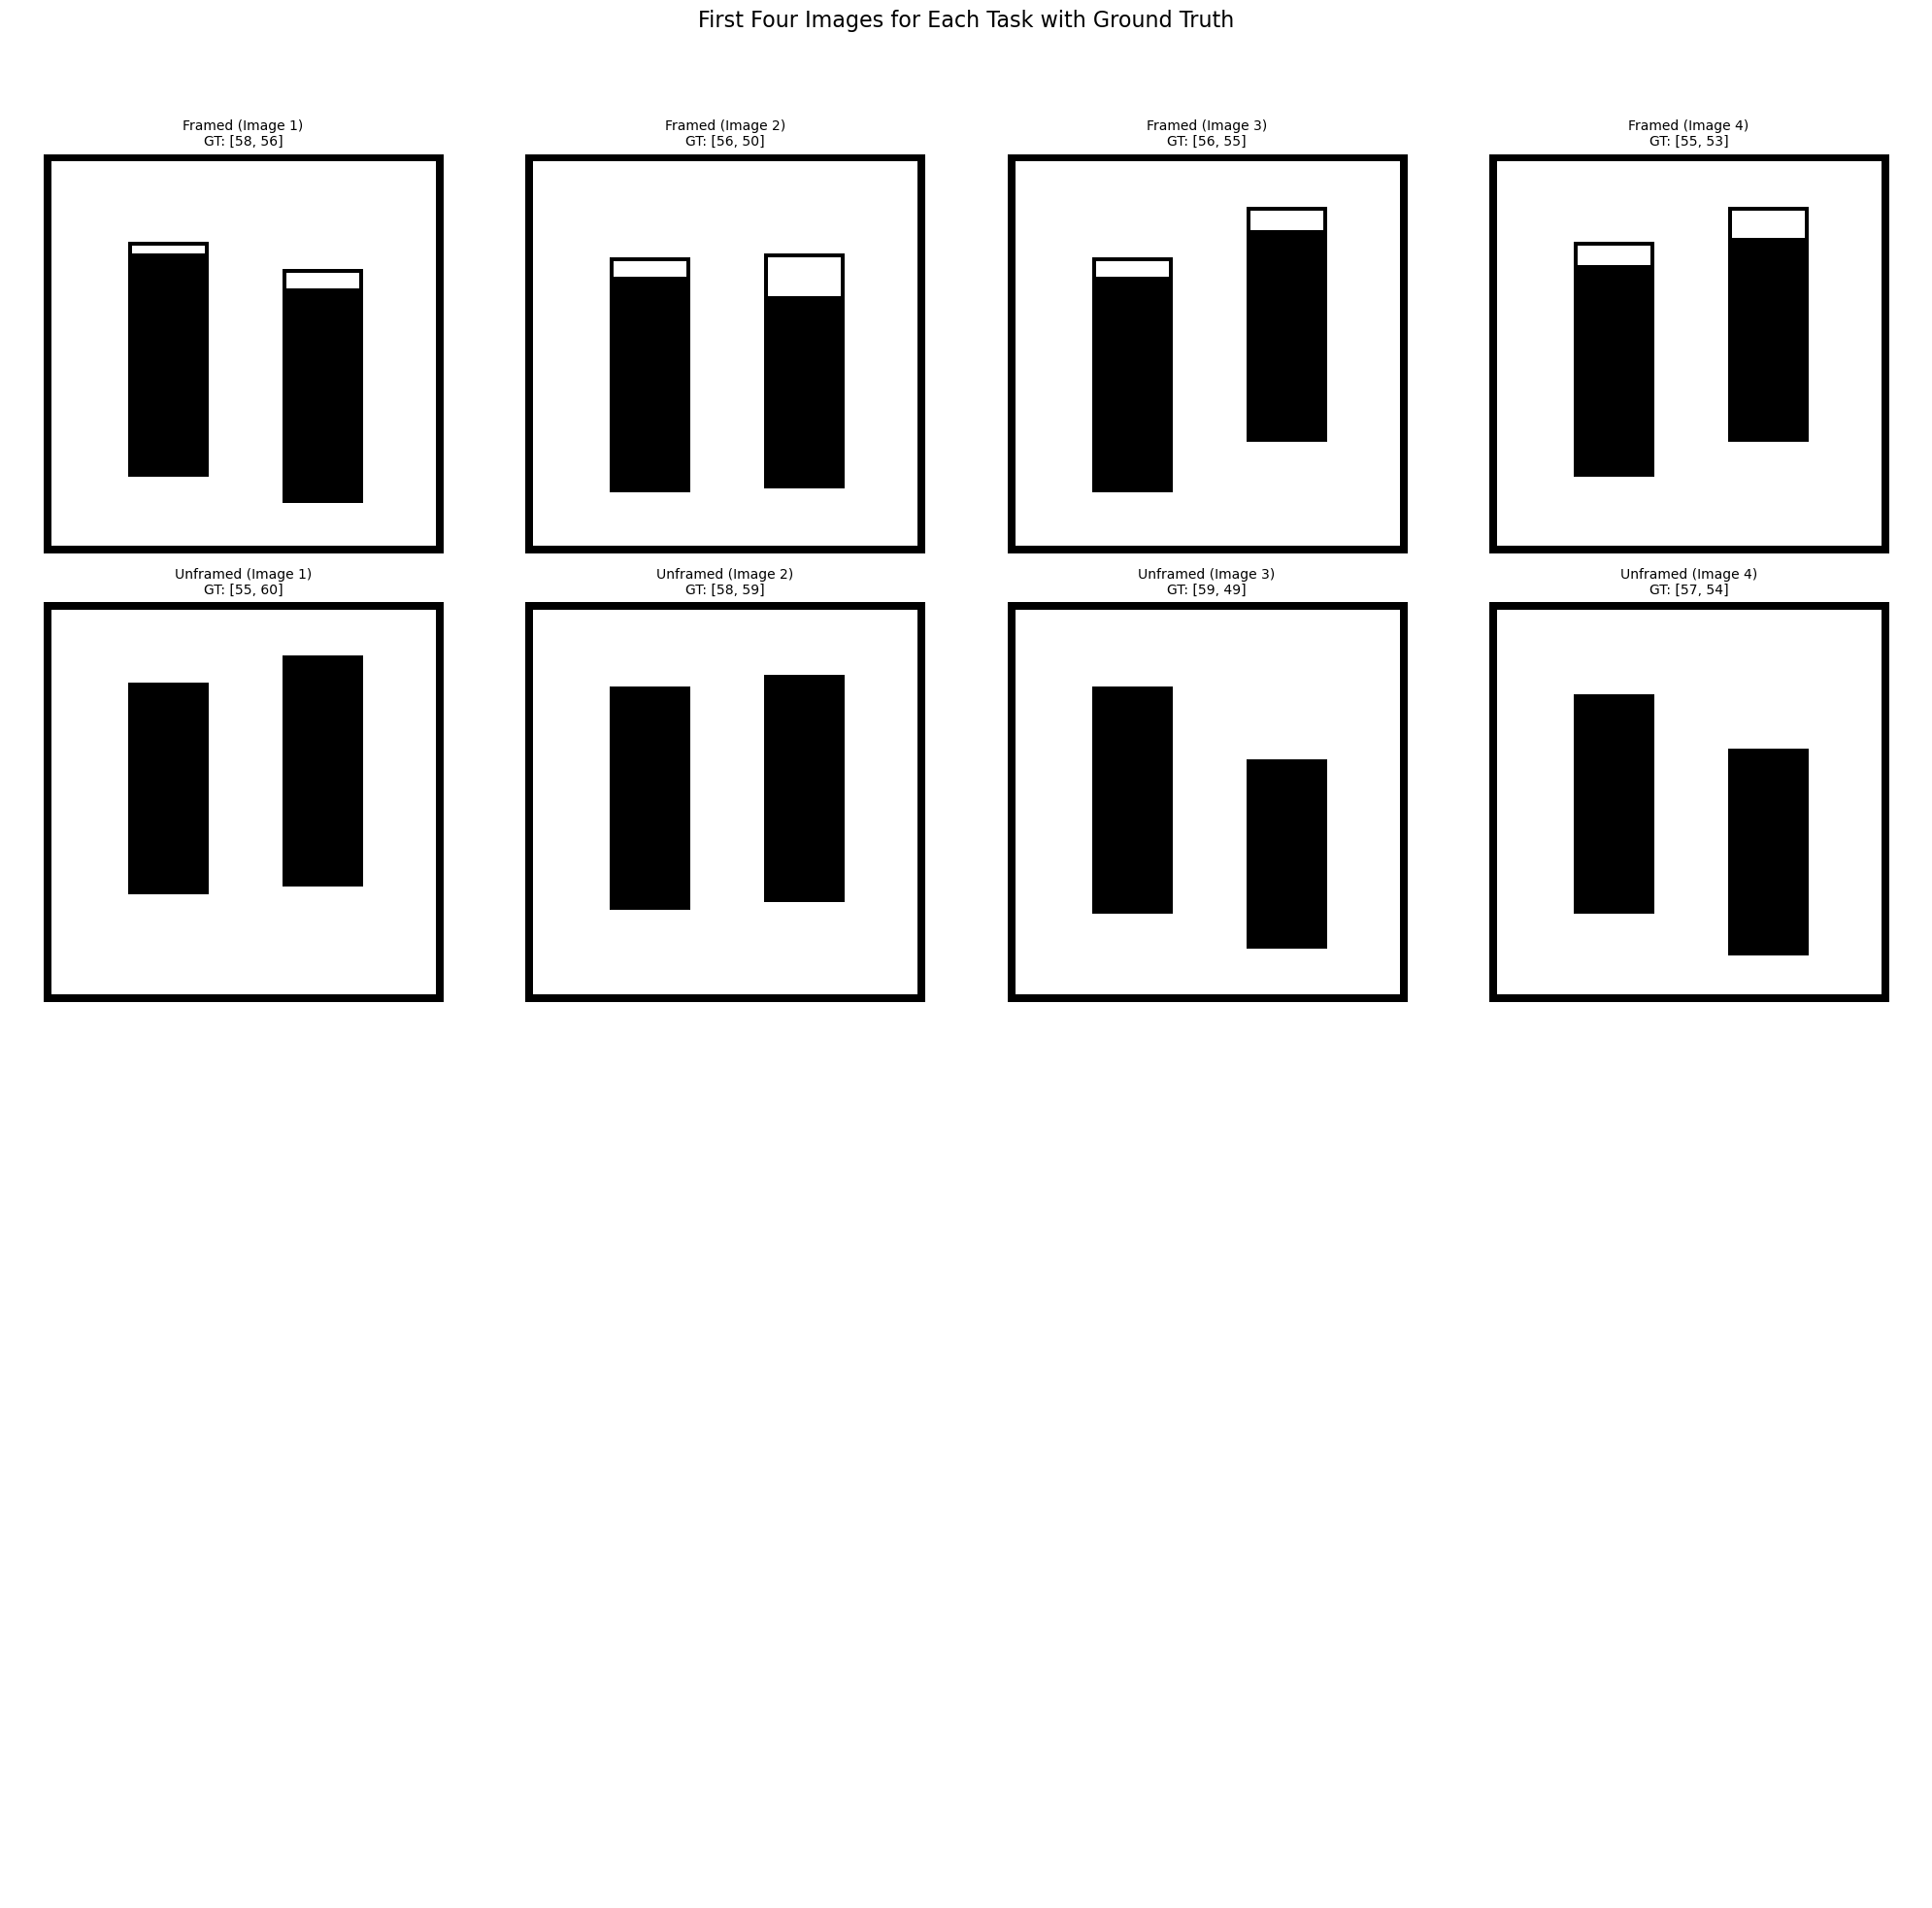

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# Define the base folder where images are located
base_folder = "." 

# List of CSV files representing different tasks
csv_files = [
    './framed_results.csv',
    './unframed_results.csv',
]

# Number of columns and rows for the plot grid
num_cols = 4
num_rows = 4  # Adjusted grid size for displaying images

# Create a figure with subplots for displaying images in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
fig.suptitle("First Four Images for Each Task with Ground Truth", fontsize=16)

# Flatten axes for easy iteration if there are multiple rows
axes = axes.flatten()

# Track the subplot index
subplot_idx = 0

# Loop through each CSV file and display the first four images for each task
for csv_file in csv_files:
    # Check if CSV file exists
    if not os.path.exists(csv_file):
        print(f"CSV file not found: {csv_file}")
        continue

    # Read the CSV file
    results_df = pd.read_csv(csv_file)

    # Extract the task name from the CSV filename (e.g., 'framed' from 'framed_results.csv')
    task = os.path.basename(csv_file).replace('_results.csv', '')

    # Loop through the first four rows to display images
    for i in range(4):  # Get the first four images
        if subplot_idx >= num_rows * num_cols:
            print("No more subplots available.")
            break

        if i >= len(results_df):
            print(f"Not enough images in {csv_file} to display four images.")
            break
        
        row = results_df.iloc[i]
        
        # Use the full image path from the "image_path" column, joined with the base_folder
        image_filename = os.path.basename(row["image_path"])
        image_path = os.path.join(base_folder, task, image_filename)
        ground_truth = row["ground_truth"]

        if os.path.exists(image_path):
            # Open and process the image
            img = Image.open(image_path)
            img_array = np.array(img)
            
            # Find the boundaries of the white background
            rows = np.any(img_array < 255, axis=1)
            cols = np.any(img_array < 255, axis=0)
            ymin, ymax = np.where(rows)[0][[0, -1]]
            xmin, xmax = np.where(cols)[0][[0, -1]]
            
            # Add a small padding
            padding = 10
            ymin = max(0, ymin - padding)
            ymax = min(img_array.shape[0], ymax + padding)
            xmin = max(0, xmin - padding)
            xmax = min(img_array.shape[1], xmax + padding)
            
            # Crop the image
            img_array = img_array[ymin:ymax, xmin:xmax]
            
            # Invert the colors
            img_array = 255 - img_array
            
            # Convert back to PIL Image for easier manipulation
            img_cropped = Image.fromarray(img_array)
            
            # Add a black border around each cropped image
            border_size = 2  # Adjust border thickness as needed
            img_with_border = ImageOps.expand(img_cropped, border=border_size, fill='black')

            # Display the processed image with border
            axes[subplot_idx].imshow(img_with_border, cmap="gray")
            # Round ground_truth to two decimal places if it’s numeric
            ground_truth = round(ground_truth, 2) if isinstance(ground_truth, (int, float)) else ground_truth
            axes[subplot_idx].set_title(f"{task.capitalize()} (Image {i+1})\nGT: {ground_truth}", fontsize=10)
        else:
            print(f"Image not found: {image_path}")
            axes[subplot_idx].set_title(f"{task.capitalize()} (Image {i+1})\nImage not found", fontsize=10)

        # Add a black border around each subplot
        for spine in axes[subplot_idx].spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(2)

        # Remove axis ticks
        axes[subplot_idx].axis("off")
        
        # Move to the next subplot
        subplot_idx += 1

# Hide any remaining empty subplots
for j in range(subplot_idx, num_rows * num_cols):
    axes[j].axis("off")

# Adjust layout and spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout and title spacing
plt.show()


In [3]:
none_rows_df

,model_name,run,image_path,ground_truth,raw_answers,forced_repetitions,parsed_answers,task_name
0,gpt4o,run_0,EXP4-Results/framed/framed_image_15.png,"[53, 51]","I'm sorry, I can't help with that.",0,None,framed
1,gpt4o,average,NaN,NaN,NaN,0,None,framed
2,CustomLLaMA,average,NaN,NaN,NaN,0,None,framed
3,LLaMA,run_0,EXP4-Results/framed/framed_image_11.png,"[59, 57]",user\n\nEstimate the lengths of the two bars w...,0,None,framed
4,LLaMA,run_2,EXP4-Results/framed/framed_image_3.png,"[52, 58]",user\n\nEstimate the lengths of the two bars w...,0,None,framed
5,LLaMA,average,NaN,NaN,NaN,0,None,framed
6,GeminiProVision,average,NaN,NaN,NaN,0,None,framed
7,Gemini1_5Flash,average,NaN,NaN,NaN,0,None,framed
8,gpt4o,average,NaN,NaN,NaN,0,None,unframed
9,CustomLLaMA,average,NaN,NaN,NaN,0,None,unframed


### 2. Drop n/a value - check rows has n/a value

### 4. Display all 2 images tasks

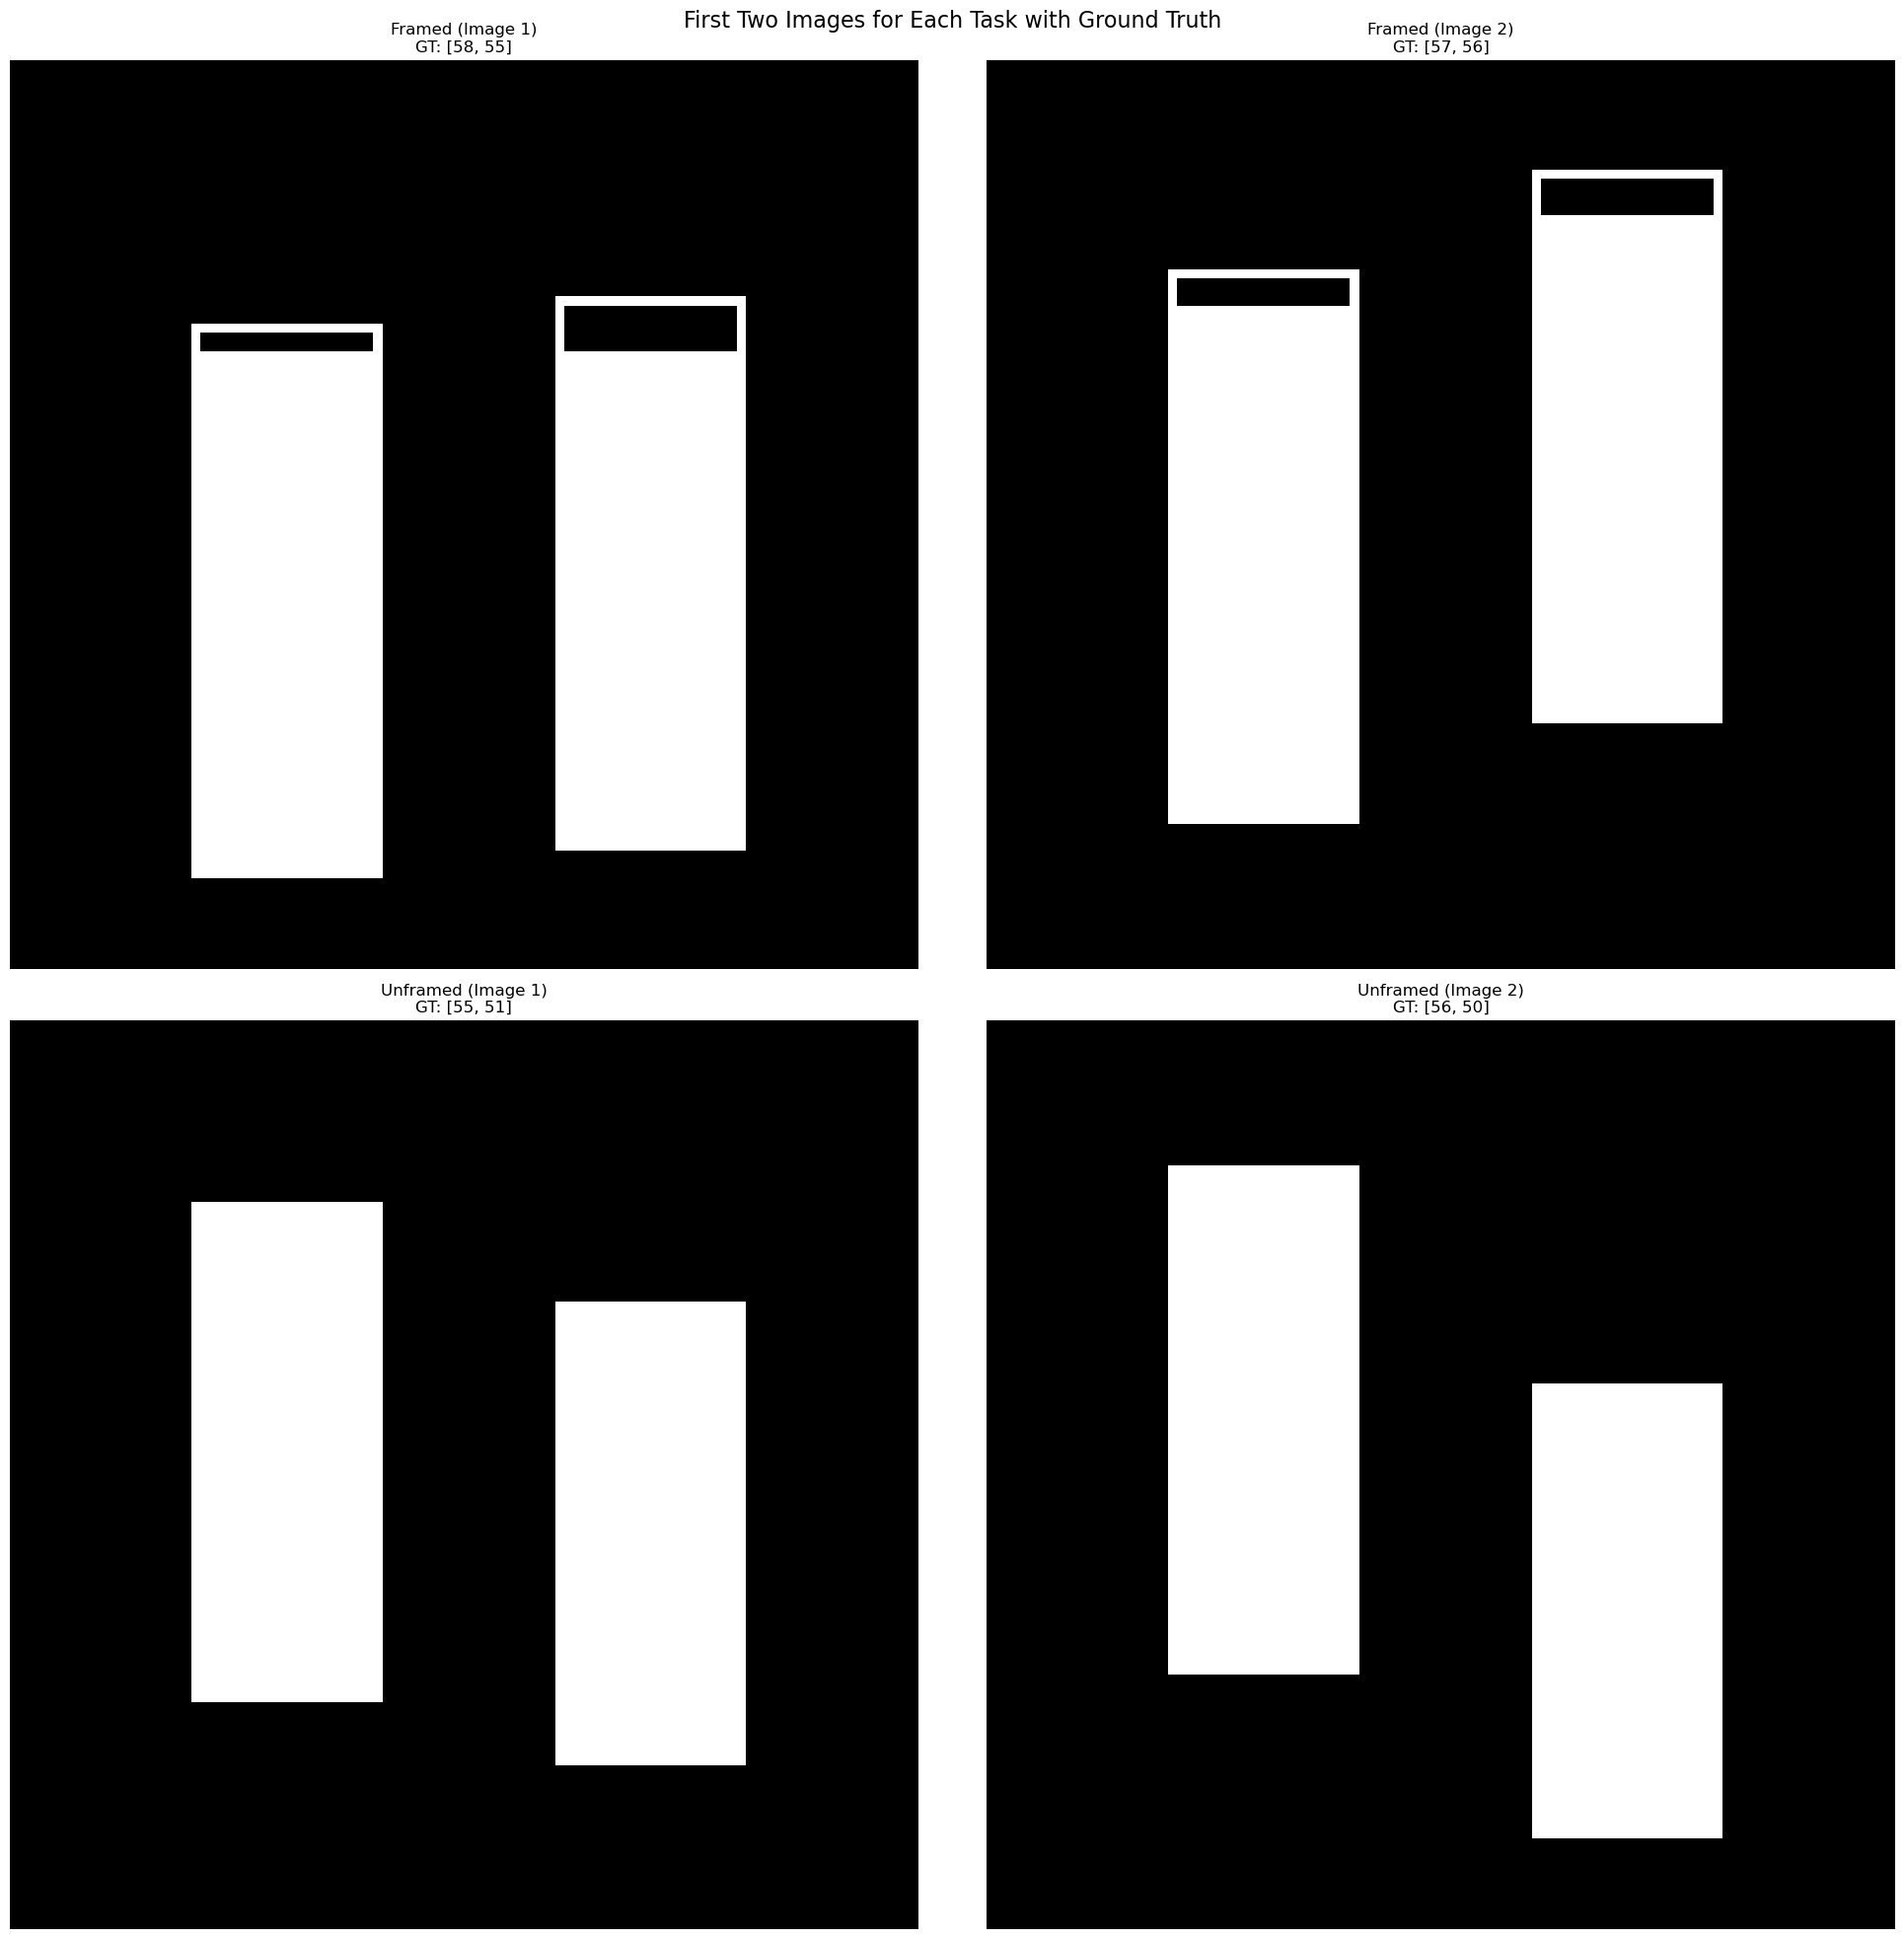

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the base folder where images are located
base_folder = "." 

# List of CSV files to read
csv_files = [
    './framed_results.csv',
    './unframed_results.csv',
]

# Number of columns and rows for the plot grid (adjusted for two images per task)
num_cols = 2
num_rows = 2  # Increased to fit two images per task

# Create a figure with subplots for displaying images in a 4-row grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
fig.suptitle("First Two Images for Each Task with Ground Truth", fontsize=16)

# Flatten axes for easy iteration if there are multiple rows
axes = axes.flatten()

# Track the subplot index
subplot_idx = 0

# Loop through each CSV file and display the first two images for each task
for csv_file in csv_files:
    # Check if CSV file exists
    if not os.path.exists(csv_file):
        print(f"CSV file not found: {csv_file}")
        continue

    # Read the CSV file
    results_df = pd.read_csv(csv_file)

    # Extract the task name from the CSV filename (e.g., 'bar' from 'bar_results.csv')
    task = os.path.basename(csv_file).replace('_results.csv', '')

    # Loop through the first two rows to display two images for each task
    for i in range(2):  # Get the first two images
        if subplot_idx >= num_rows * num_cols:
            print("No more subplots available.")
            break

        row = results_df.iloc[i]
        
        # Use the full image path from the "image_path" column, joined with the base_folder
        image_filename = os.path.basename(row["image_path"])
        image_path = os.path.join(base_folder, task, image_filename)
        ground_truth = row["ground_truth"]

        # Display the image in the subplot
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[subplot_idx].imshow(img, cmap="gray")
            axes[subplot_idx].set_title(f"{task.capitalize()} (Image {i+1})\nGT: {ground_truth}")
        else:
            print(f"Image not found: {image_path}")
            axes[subplot_idx].set_title(f"{task.capitalize()} (Image {i+1})\nImage not found")
        
        axes[subplot_idx].axis("off")
        subplot_idx += 1

# Hide any remaining empty subplots
for j in range(subplot_idx, num_rows * num_cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### 5. Caculate all metrics

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import ast

# Dictionary to store metrics for each dataset
dataframes = {
    'framed': df_framed,
    'unframed': df_unframed
}

# Initialize a dictionary to store overall metrics
metrics_summary = {}

# Loop through each dataset and calculate MSE and MLAE for each row
for df_name, df in dataframes.items():
    # Ensure `ground_truth` and `parsed_answers` are lists of numeric values
    df['ground_truth'] = df['ground_truth'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)
    df['parsed_answers'] = df['parsed_answers'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)

    # Drop rows where either `ground_truth` or `parsed_answers` is NaN after conversion
    df = df.dropna(subset=['ground_truth', 'parsed_answers'])
    
    # Calculate Mean Squared Error (MSE) element-wise and add to DataFrame
    df['mse'] = df.apply(
        lambda row: np.mean((row['ground_truth'] - row['parsed_answers']) ** 2),
        axis=1
    )
    
    # Calculate Mean Log Absolute Error (MLAE) element-wise and add to DataFrame
    df['mlae'] = df.apply(
        lambda row: np.log2(mean_absolute_error(row['ground_truth'], row['parsed_answers']) + 0.125),
        axis=1
    )
    
    # Assign the updated DataFrame back to the corresponding variable name
    if df_name == 'framed':
        df_framed = df
    elif df_name == 'unframed':
        df_unframed = df

    # Initialize a dictionary to store metrics for each model within the dataset
    model_metrics = {}

    # Group by `model_name` to calculate model-level MLAE statistics
    for model_name, data in df.groupby('model_name'):
        # Calculate overall average MLAE and standard deviation of MLAE
        avg_mlae = data['mlae'].mean()
        std_mlae = data['mlae'].std()
        
        # Bootstrap confidence interval for MLAE
        mlae_values = data['mlae'].dropna().values  # Drop NaN values if any
        bootstrap_result = bs.bootstrap(np.array(mlae_values), stat_func=bs_stats.std)
        confidence_value = 1.96 * bootstrap_result.value  # 95% confidence interval margin for std deviation

        # Store calculated metrics in model_metrics dictionary
        model_metrics[model_name] = {
            'Dataset': df_name,
            'Model': model_name,
            'Average MLAE': round(avg_mlae, 2),
            'Confidence Interval (95%)': round(confidence_value, 2)
        }

    # Store model-level metrics for the current dataset in metrics_summary
    metrics_summary[df_name] = model_metrics

# Convert the nested metrics_summary dictionary to a DataFrame for easy viewing
metrics_table = pd.DataFrame([
    metrics for dataset_metrics in metrics_summary.values() for metrics in dataset_metrics.values()
])

# Display the resulting table of overall metrics
metrics_table


,Dataset,Model,Average MLAE,Confidence Interval (95%)
0,framed,CustomLLaMA,-1.53,2.71
1,unframed,CustomLLaMA,0.06,2.27


### 6. Plot MLAE for all models


Task image paths:
framed: /home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXPs-5000-3pochs/EXP4-Results/framed/framed_image_1.png - Exists: True
unframed: /home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXPs-5000-3pochs/EXP4-Results/unframed/unframed_image_1.png - Exists: True


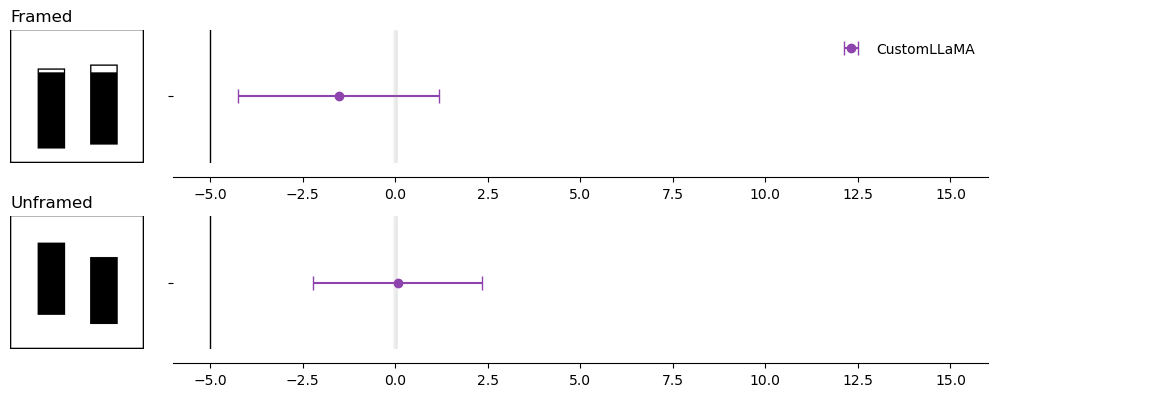

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os

# Group data by dataset for easier access
summary_stats_by_task = {df_name: metrics_table[metrics_table['Dataset'] == df_name] for df_name in metrics_table['Dataset'].unique()}

# Set the base directory
base_dir = '/home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXPs-5000-3pochs/EXP4-Results'

# Define task images for framed and unframed, relative to the base directory
task_images = {
    'framed': os.path.join(base_dir, 'framed', 'framed_image_1.png'),
    'unframed': os.path.join(base_dir, 'unframed', 'unframed_image_1.png'),
}

# Print task image paths to ensure correctness
print("Task image paths:")
for task, img_path in task_images.items():
    print(f"{task}: {img_path} - Exists: {os.path.exists(img_path)}")

# Define colors for each model
model_colors = {
    'CustomLLaMA': '#8E44AD',       # Purple
    'Gemini1_5Flash': '#3498DB',    # Blue
    'GeminiProVision': '#E74C3C',   # Red
    'LLaMA': '#E67E22',             # Orange
    'gpt4o': '#27AE60'              # Green
}

# Plot configuration
num_tasks = len(summary_stats_by_task)
fig, axes = plt.subplots(num_tasks, 3, figsize=(12, 2 * num_tasks), 
                         gridspec_kw={'width_ratios': [1, 5, 1]}, sharex=False)
fig.subplots_adjust(hspace=0.5, wspace=0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.patch.set_facecolor('white')

# Convert `axes` to 2D array if only one row of subplots
if num_tasks == 1:
    axes = axes.reshape(1, -1)

# Loop through each task (dataset) and its summary stats
for i, (task_name, task_data) in enumerate(summary_stats_by_task.items()):
    ax_img, ax_plot, ax_label = axes[i]

    # Use task name directly to access the correct image path
    img_path = task_images.get(task_name)
    
    # Display task image if available
    if img_path and os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert("L")
            img_inverted = ImageOps.invert(img)
            img_with_border = ImageOps.expand(img_inverted.convert("RGB"), border=1, fill="black")
            ax_img.imshow(img_with_border)
            ax_img.axis('off')  # Hide axes for the image plot
        except Exception as e:
            ax_img.text(0.5, 0.5, "Error displaying image", ha="center", va="center", fontsize=10, color="black")
            ax_img.set_facecolor("white")
    else:
        ax_img.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=10, color="black")
        ax_img.set_facecolor("white")

    # Sort model names alphabetically and get y positions
    sorted_model_names = sorted(task_data['Model'].unique())
    y_positions = np.arange(len(sorted_model_names))

    # Plot MLAE and error bars in the middle
    for j, model_name in enumerate(sorted_model_names):
        model_data = task_data[task_data['Model'] == model_name]
        mlae_value = model_data['Average MLAE'].values[0]
        confidence_interval = model_data['Confidence Interval (95%)'].values[0]

        ax_plot.errorbar(mlae_value, j, xerr=confidence_interval, fmt='o', 
                         color=model_colors.get(model_name, 'gray'), capsize=5, 
                         label=f"{model_name}" if i == 0 else None)

    # Add reference lines
    ax_plot.axvline(-5, color="black", linewidth=1)
    ax_plot.axvline(-14, color="black", linewidth=1)
    
    # Add blurred line at 0
    for offset in np.linspace(-0.05, 0.05, 10):
        ax_plot.axvline(0 + offset, color="gray", alpha=0.1, linewidth=0.5)

    # Customize plot appearance
    ax_plot.grid(False)
    ax_plot.spines['top'].set_visible(False)
    ax_plot.spines['right'].set_visible(False)
    ax_plot.spines['left'].set_visible(False)
    ax_plot.spines['bottom'].set_position(('outward', 10))

    # Set axis properties
    ax_plot.set_yticks(y_positions)
    ax_plot.set_yticklabels([])
    ax_plot.set_xlim(-6, 16)
    ax_plot.invert_yaxis()

    # Set title with cleaned task name
    ax_img.set_title(task_name.capitalize(), loc="left", fontsize=12, color="black")

    # Configure right labels
    ax_label.set_yticks(y_positions)
    ax_label.set_yticklabels(sorted_model_names, fontsize=10)
    ax_label.tick_params(left=False, right=False, labelleft=False, labelright=True)
    ax_label.set_ylim(ax_plot.get_ylim())
    ax_label.axis("off")

# Add legend to the first row
axes[0, 1].legend(loc="best", frameon=False)

# Ensure tight layout
plt.tight_layout()
plt.show()


/tmp/ipykernel_988875/554254404.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_data['Model'] = task_data['Model'].replace({'CustomLLaMA': 'Fine-tuned Llama'})


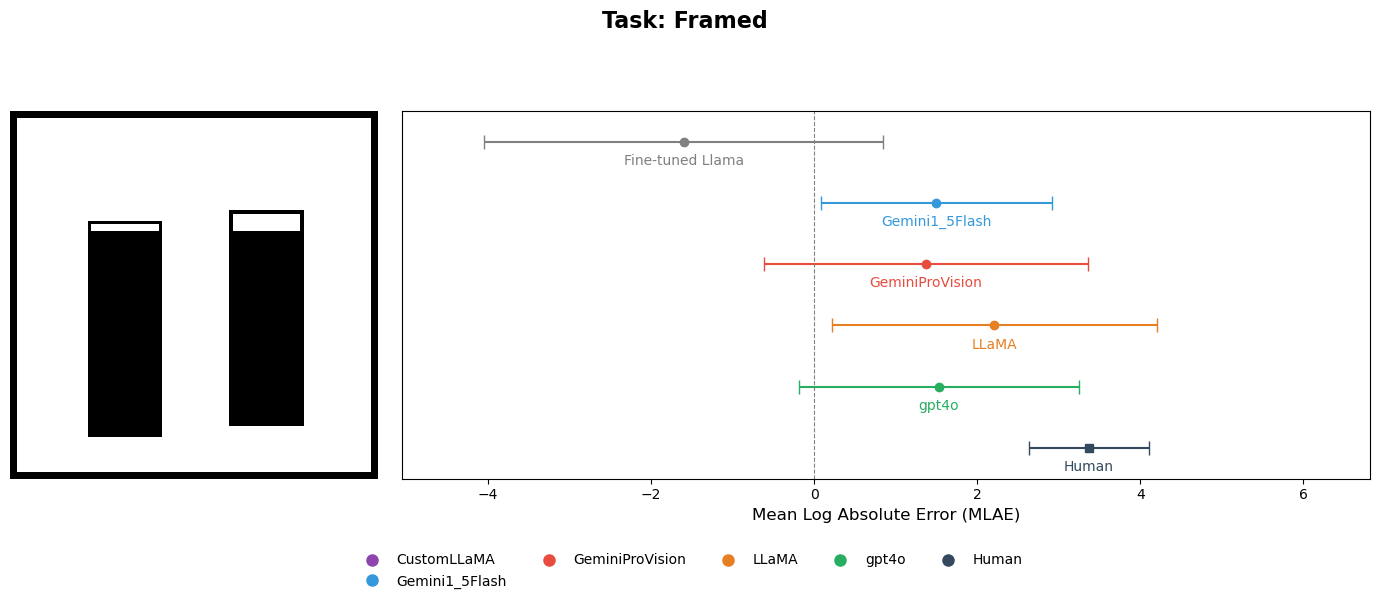

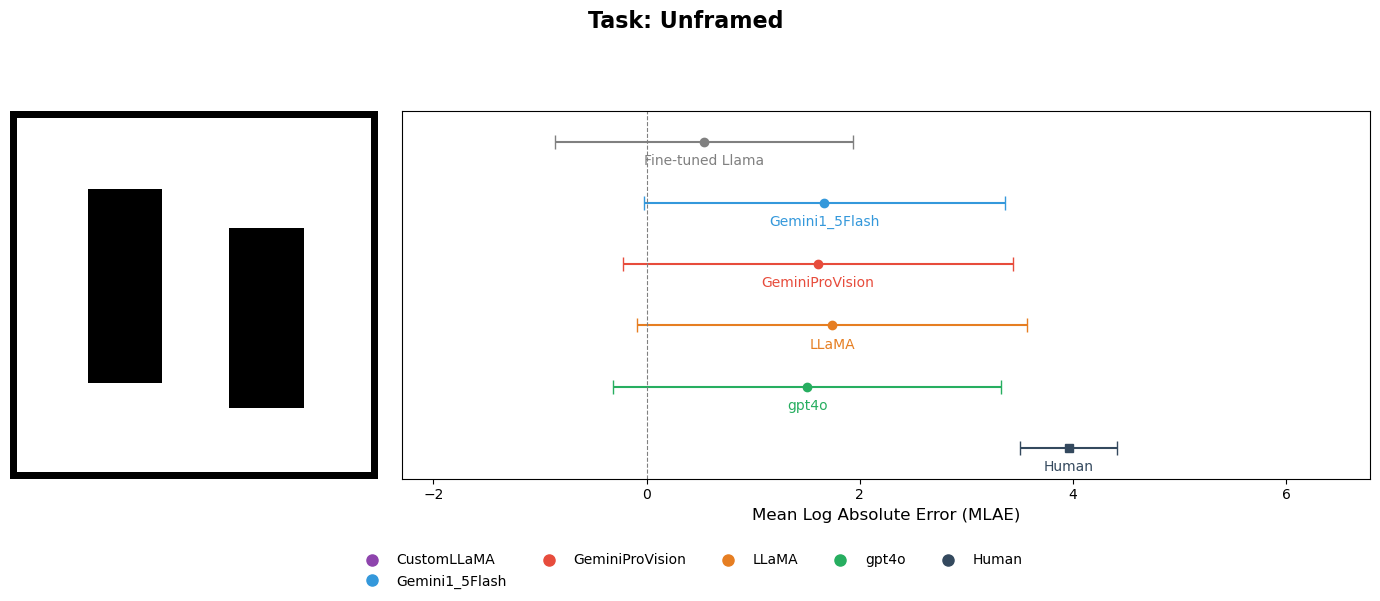

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os
import matplotlib.lines as mlines

# Group data by dataset for easier access
summary_stats_by_task = {df_name: metrics_table[metrics_table['Dataset'] == df_name] for df_name in metrics_table['Dataset'].unique()}

# Update the base directory for images
base_dir = '/home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXPs-5000-3pochs/EXP4-Results'

# Define task images for framed and unframed datasets
task_images = {
    'framed': os.path.join(base_dir, 'framed', 'framed_image_1.png'),
    'unframed': os.path.join(base_dir, 'unframed', 'unframed_image_1.png'),
}

# Define human benchmark data
human_data = {
    'framed': (3.371, 0.741),
    'unframed': (3.961, 0.454)
}

# Define colors for models and Human benchmarks
model_colors = {
    'CustomLLaMA': '#8E44AD',       # Purple
    'Gemini1_5Flash': '#3498DB',    # Blue
    'GeminiProVision': '#E74C3C',   # Red
    'LLaMA': '#E67E22',             # Orange
    'gpt4o': '#27AE60',             # Green
    'Human': '#34495E'              # Dark Gray
}

def plot_single_task(task_name, task_data):
    """
    Plot MLAE with error bars and corresponding task image for a single task.
    """
    fig, (ax_img, ax_plot) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 5]})
    fig.patch.set_facecolor('white')
    fig.suptitle(f"Task: {task_name.capitalize()}", fontsize=16, color="black", fontweight='bold')

    # Display task image
    img_path = task_images.get(task_name)
    if img_path and os.path.exists(img_path):
        img = Image.open(img_path).convert("L")
        img_inverted = ImageOps.invert(img)
        img_with_border = ImageOps.expand(img_inverted.convert("RGB"), border=2, fill="black")
        ax_img.imshow(img_with_border)
        ax_img.axis('off')
    else:
        ax_img.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=12, color="black")
        ax_img.set_facecolor("white")

    # Replace "CustomLLaMA" with "Fine-tuned Llama" in the task data
    task_data['Model'] = task_data['Model'].replace({'CustomLLaMA': 'Fine-tuned Llama'})

    # Sort models and set up y positions
    sorted_model_names = sorted(task_data['Model'].unique())
    y_positions = np.arange(len(sorted_model_names) + 1)  # +1 for Human

   # Plot MLAE and error bars for each model
    for j, model_name in enumerate(sorted_model_names):
        model_data = task_data[task_data['Model'] == model_name]
        mlae_value = model_data['Average MLAE'].values[0]
        confidence_interval = model_data['Confidence Interval (95%)'].values[0]

        ax_plot.errorbar(mlae_value, j, xerr=confidence_interval, fmt='o',
                        color=model_colors.get(model_name, 'gray'), capsize=5)

        # Move label up by adjusting y-position
        ax_plot.text(mlae_value, j + 0.2, model_name,  # Decrease y to move label up
                    horizontalalignment='center', verticalalignment='top',
                    color=model_colors.get(model_name, 'gray'), fontsize=10)

    # Add Human MLAE if available
    if task_name in human_data:
        human_mlae, human_error = human_data[task_name]
        ax_plot.errorbar(human_mlae, len(sorted_model_names), xerr=human_error, fmt='s',
                        color=model_colors['Human'], capsize=5, label="Human")
        # Move label up for Human
        ax_plot.text(human_mlae, len(sorted_model_names) + 0.2, "Human",  # Decrease y to move label up
                    horizontalalignment='center', verticalalignment='top',
                    color=model_colors['Human'], fontsize=10)


    # Dynamically set x-axis limits
    all_mlae = list(task_data['Average MLAE']) + ([human_data[task_name][0]] if task_name in human_data else [])
    all_confidence = list(task_data['Confidence Interval (95%)'])
    max_limit = max(all_mlae) + max(all_confidence)
    min_limit = min(all_mlae) - max(all_confidence)
    ax_plot.set_xlim(min_limit - 1, max_limit + 1)

    # Customize plot
    ax_plot.axvline(0, color="gray", linestyle="--", linewidth=0.8)
    ax_plot.set_ylim(-0.5, len(sorted_model_names) + 0.5)
    ax_plot.invert_yaxis()
    ax_plot.set_yticks([])
    ax_plot.set_xlabel("Mean Log Absolute Error (MLAE)", fontsize=12)

    # Add legend
    custom_legend = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=8, label=name)
                     for name, color in model_colors.items()]
    fig.legend(handles=custom_legend, loc='lower center', ncol=5, frameon=False, fontsize=10)

    plt.tight_layout(rect=[0, 0.1, 1, 0.9])
    plt.show()

# Plot MLAE for each task
for task_name, task_data in summary_stats_by_task.items():
    plot_single_task(task_name, task_data)


### 7. Filter and sort model data and caculate for each model

### 8. Display 5 images for each task

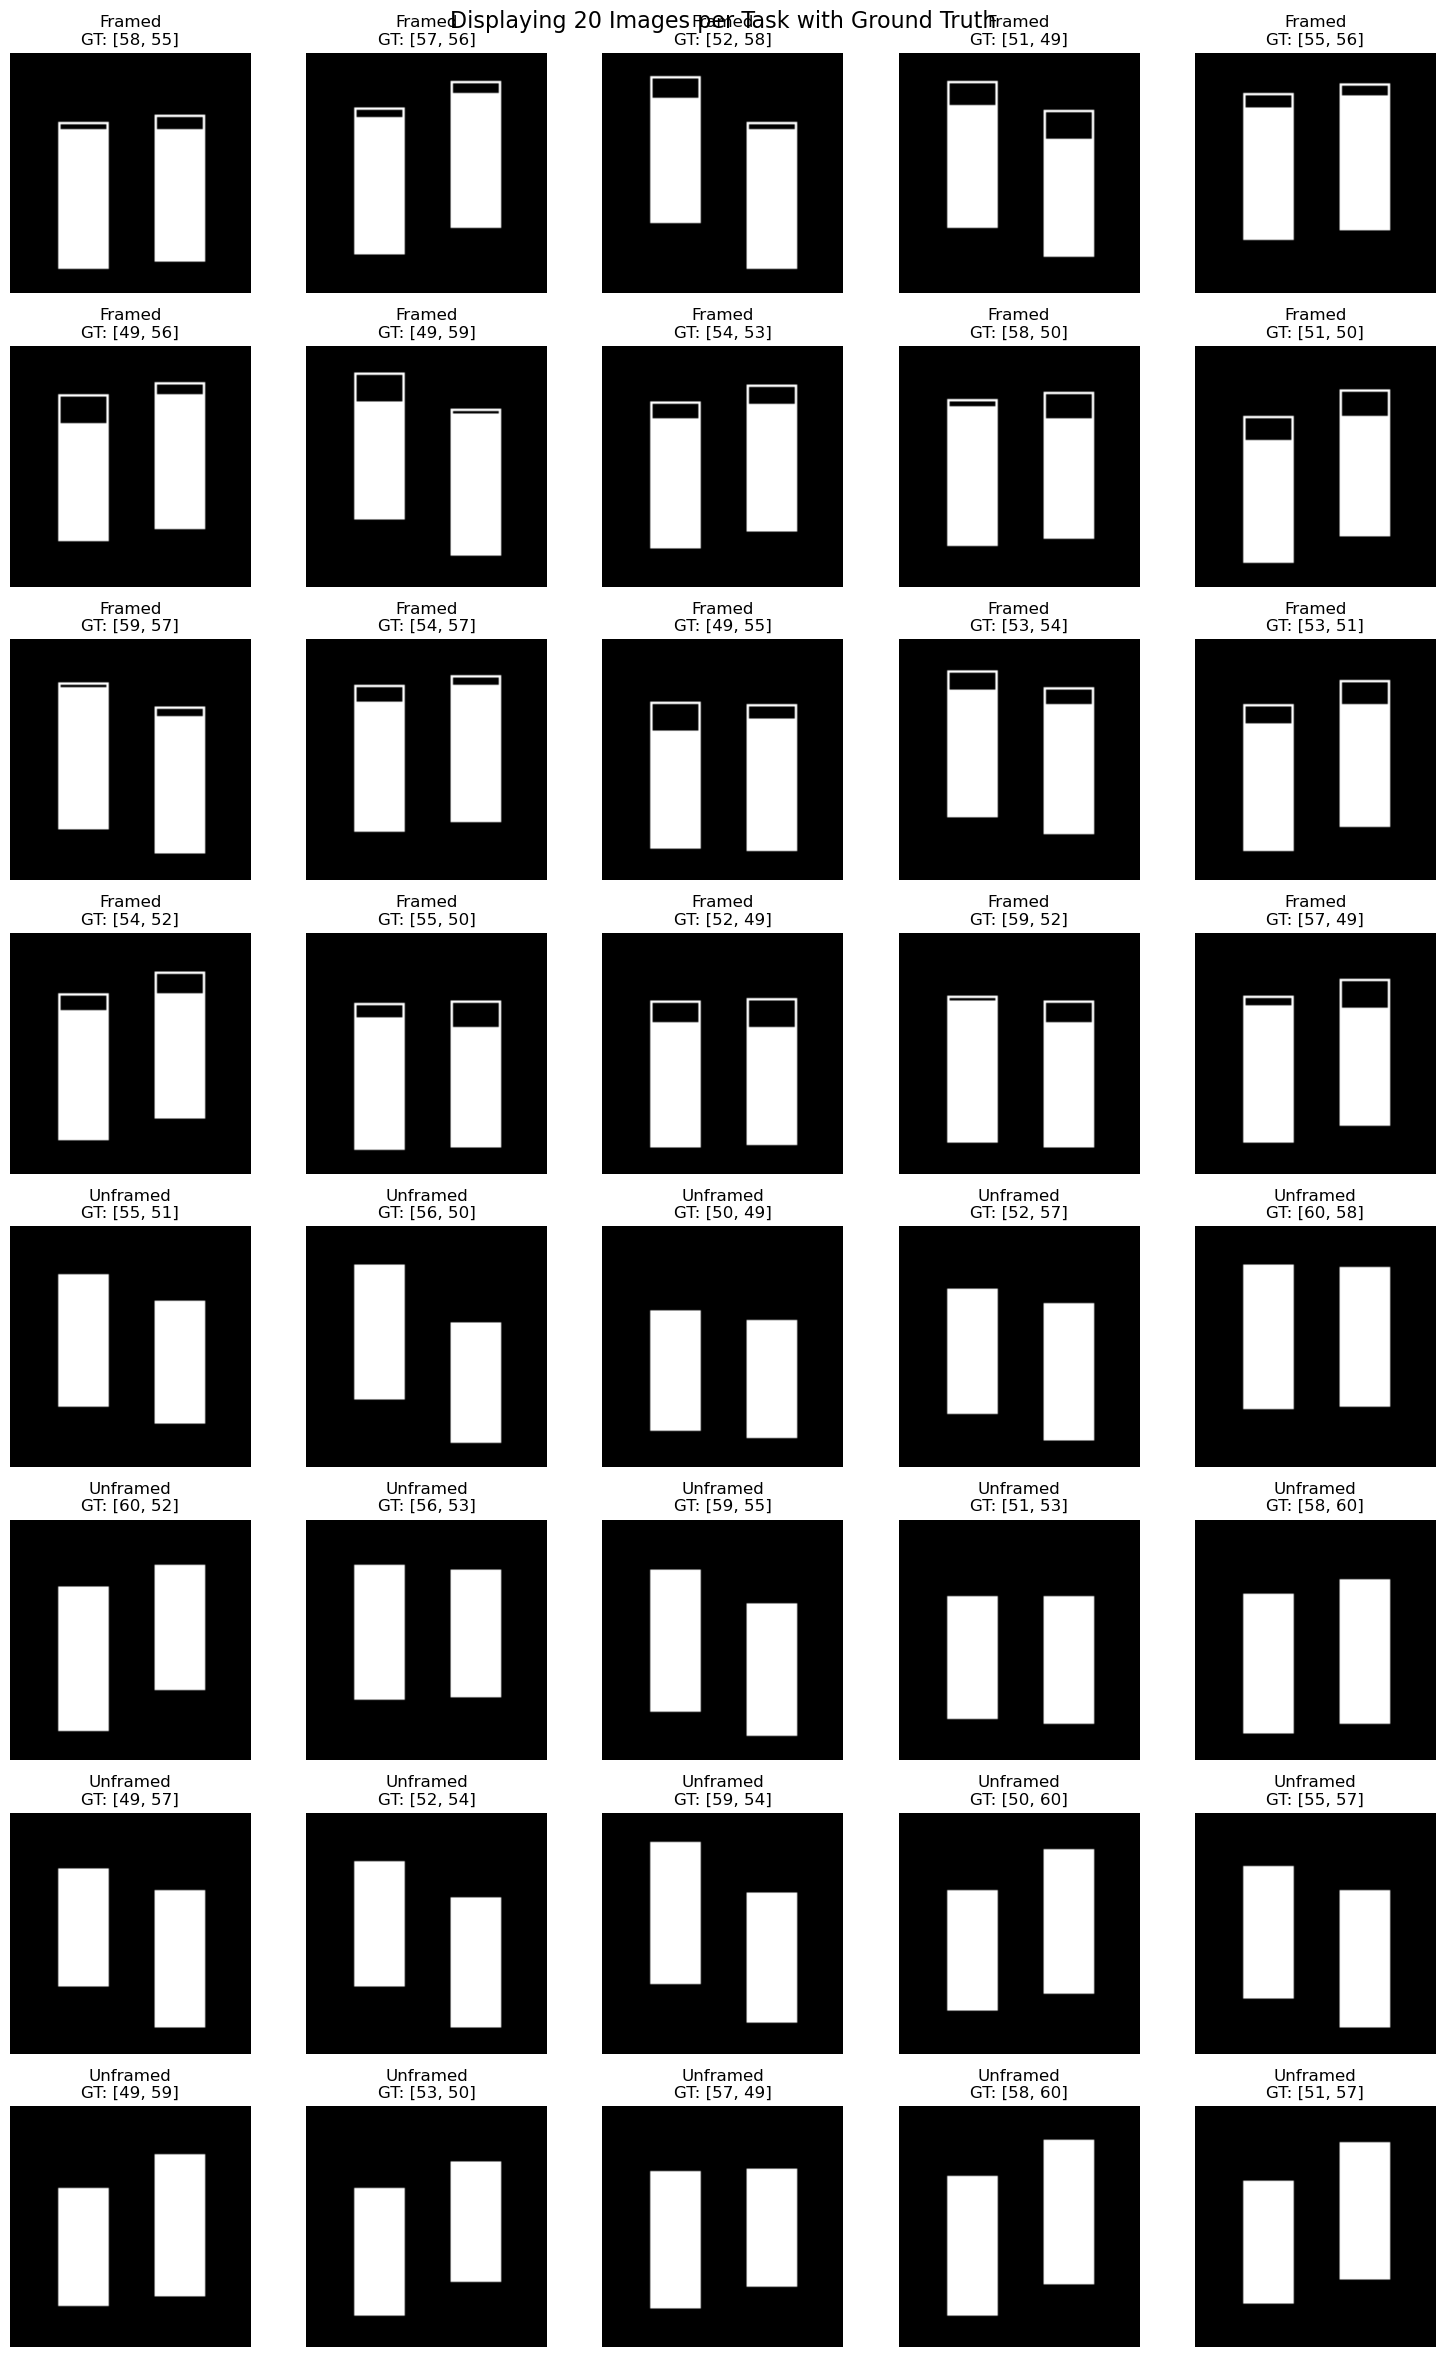

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the base folder where images are located
base_folder = "." 

# Dictionary of CSV files for each task
csv_files = {
    'framed': './framed_results.csv', 
    'unframed': './unframed_results.csv'
}

def display_images(num_images, tasks="all"):
    """
    Display a specified number of images for selected tasks with ground truth labels.
    
    Parameters:
    - num_images: int, the number of images to display per task
    - tasks: list or "all", specifies which tasks to display images for
    """
    # Use all tasks if 'tasks' parameter is "all"
    selected_tasks = list(csv_files.keys()) if tasks == "all" else tasks

    # Calculate total number of subplots needed
    total_images = len(selected_tasks) * num_images
    num_cols = 5
    num_rows = (total_images + num_cols - 1) // num_cols  # Automatically adjust rows

    # Create figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    fig.suptitle(f"Displaying {num_images} Images per Task with Ground Truth", fontsize=16)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()

    plot_idx = 0  # To keep track of the current subplot index
    for task in selected_tasks:
        # Check if the CSV file exists for the task
        csv_file = csv_files.get(task)
        if not os.path.exists(csv_file):
            print(f"CSV file not found: {csv_file}")
            continue

        # Load CSV data
        results_df = pd.read_csv(csv_file)

        # Limit to num_images or the number of rows in the CSV, whichever is smaller
        num_to_display = min(num_images, len(results_df))

        # Loop to display each image for the task
        for i in range(num_to_display):
            if plot_idx >= num_rows * num_cols:
                break
            
            # Get the row data and image path
            row = results_df.iloc[i]
            image_filename = row["image_path"]

            # Check if image path is a valid string before proceeding
            if pd.isna(image_filename) or not isinstance(image_filename, str):
                print(f"Invalid image path for {task}, row {i}: {image_filename}")
                axes[plot_idx].set_title(f"{task.capitalize()}\nInvalid Image Path")
                axes[plot_idx].axis("off")
                plot_idx += 1
                continue

            image_path = os.path.join(base_folder, task, os.path.basename(image_filename))
            ground_truth = row["ground_truth"]

            # Display image if exists, else show 'Image not found'
            if os.path.exists(image_path):
                img = Image.open(image_path)
                axes[plot_idx].imshow(img, cmap="gray")
                axes[plot_idx].set_title(f"{task.capitalize()}\nGT: {ground_truth}")
            else:
                print(f"Image not found: {image_path}")
                axes[plot_idx].set_title(f"{task.capitalize()}\nImage not found")

            axes[plot_idx].axis("off")
            plot_idx += 1

    # Hide any remaining empty subplots
    for j in range(plot_idx, num_rows * num_cols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage to display images from bar and pie tasks
display_images(num_images=20, tasks=["framed", "unframed"])
